Datos extraidos de: https://www.kaggle.com/aungpyaeap/supermarket-sales
**NOTA:** Este notebook solo esta como prueba, por que la parte de aplicación del algoritmo a priori puede no estar correcta.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
# cargando datos
sales = pd.read_csv('supermarket_sales - Sheet1.csv')
sales.head()

Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  
0  13:08      Ewallet  522.83                 4.761905       26.1415     9.1  
1  10:29         Cash   76.40                 4.761905        3.8200     9.6  
2  13:23  Credit card  324.31                 4.761905       16.2155     7.4  
3  20:33      Ewallet  465.76                 4.761905       23.2880     8.4  
4  10:37      Ewallet  604.17                 4.761905       30.2085     5.3

In [244]:
sales.shape

(1000, 17)

## Análisis exploratorio de datos (EDA)

Para la aplicación del algoritmo apriori para generar reglas de asociación se van a eliminar todas las variables no categóricas y convertir algunas en categóricas.

In [3]:
# Convirtiendo la fecha en variable categórica clasificando por meses
def clasificarPorMes(fecha):
    mes = fecha.split('/')[0]
    if mes == '1':
        return 'Junary'
    elif mes == '2':
        return 'Februrary'
    elif mes == '3':
        return 'March'
sales['Month'] = sales['Date'].apply(clasificarPorMes)
sales['Month'].head(10)

0       Junary
1        March
2        March
3       Junary
4    Februrary
5        March
6    Februrary
7    Februrary
8       Junary
9    Februrary
Name: Month, dtype: object

In [4]:
# print(sales['Time'].unique()) # tal vez se puede categorizar por mañana, tardes
# Categorizando la hora en  mañana, tarde y noche
def clasificarPeriodoDelDia(time):
    hora = int(time.split(':')[0])
    if hora > 5 and hora < 12:
        return 'morning'
    if hora >=12 and hora < 19:
        return 'noon'
    if hora >= 19 or (hora > 0 and hora <= 5):
        return 'night'
sales['Day Period'] = sales['Time'].apply(clasificarPeriodoDelDia)
sales['Day Period'].head(10)

0       noon
1    morning
2       noon
3      night
4    morning
5       noon
6       noon
7    morning
8       noon
9       noon
Name: Day Period, dtype: object

In [5]:
sales.head(10)

Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   
5  699-14-3026      C  Naypyitaw        Normal    Male   
6  355-53-5943      A     Yangon        Member  Female   
7  315-22-5665      C  Naypyitaw        Normal  Female   
8  665-32-9167      A     Yangon        Member  Female   
9  692-92-5582      B   Mandalay        Member  Female   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   
5  Electronic accessories       85.39         7  29.8865  627.6165  3/25/2019   
6  Electronic accessories       68.84         6  20.6520  433.6920  2/25/2019   
7      Home and lifestyle       73.56        10  36.7800  772.3800  2/24/2019   
8       Health and beauty       36.26         2   3.6260   76.1460  1/10/2019   
9      Food and beverages       54.84         3   8.2260  172.7460  2/20/2019   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  \
0  13:08      Ewallet  522.83                 4.761905       26.1415     9.1   
1  10:29         Cash   76.40                 4.761905        3.8200     9.6   
2  13:23  Credit card  324.31                 4.761905       16.2155     7.4   
3  20:33      Ewallet  465.76                 4.761905       23.2880     8.4   
4  10:37      Ewallet  604.17                 4.761905       30.2085     5.3   
5  18:30      Ewallet  597.73                 4.761905       29.8865     4.1   
6  14:36      Ewallet  413.04                 4.761905       20.6520     5.8   
7  11:38      Ewallet  735.60                 4.761905       36.7800     8.0   
8  17:15  Credit card   72.52                 4.761905        3.6260     7.2   
9  13:27  Credit card  164.52                 4.761905        8.2260     5.9   

       Month Day Period  
0     Junary       noon  
1      March    morning  
2      March       noon  
3     Junary      night  
4  Februrary    morning  
5      March       noon  
6  Februrary       noon  
7  Februrary    morning  
8     Junary       noon  
9  Februrary       noon

In [31]:
for col in sales.columns:
    print('***',  col, '\n' sales[col].value_counts())

*** Branch 
 A    340
B    332
C    328
Name: Branch, dtype: int64
*** City 
 Yangon       340
Mandalay     332
Naypyitaw    328
Name: City, dtype: int64
*** Customer type 
 Member    501
Normal    499
Name: Customer type, dtype: int64
*** Gender 
 Female    501
Male      499
Name: Gender, dtype: int64
*** Product line 
 Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: Product line, dtype: int64
*** Quantity 
 10    119
1     112
4     109
7     102
5     102
6      98
9      92
2      91
3      90
8      85
Name: Quantity, dtype: int64
*** Payment 
 Ewallet        345
Cash           344
Credit card    311
Name: Payment, dtype: int64
*** Month 
 Junary       352
March        345
Februrary    303
Name: Month, dtype: int64
*** Day Period 
 noon       621
morning    191
night      188
Name: Day Period, dtype: int64


Text(0.5, 1.0, 'Objetos vendidos según tipo de línea de productos')

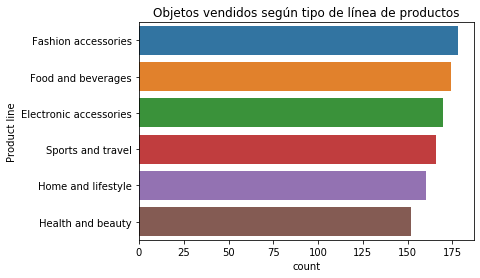

In [6]:
grafico = sns.countplot(y='Product line', data=sales, order = sales['Product line'].value_counts().index)
grafico.set_title('Objetos vendidos según tipo de línea de productos')

Text(0.5, 1.0, 'Cantidad de compras segun canal de pago')

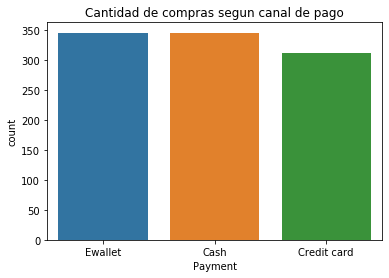

In [7]:
grafico = sns.countplot(x="Payment", data =sales)
grafico.set_title("Cantidad de compras segun canal de pago")

Text(0.5, 1.0, 'Productos vendidos por género y línea de productos')

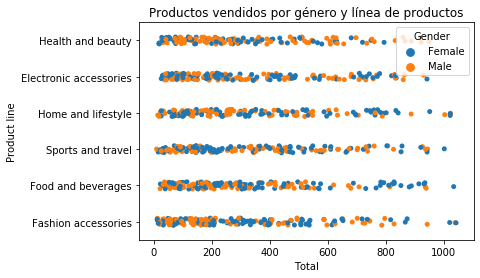

In [8]:
grafico = sns.stripplot(y = 'Product line', x = 'Total', hue = 'Gender', data=sales )
grafico.set_title("Productos vendidos por género y línea de productos")

In [9]:
grafico.set_title("Productos vendidos por género y línea de productos")

Text(0.5, 1, 'Productos vendidos por género y línea de productos')

Text(0.5, 1.0, 'Ventas por período del día')

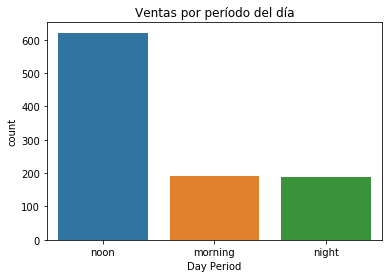

In [10]:
grafico = sns.countplot(x = 'Day Period', data = sales)
grafico.set_title("Ventas por período del día")

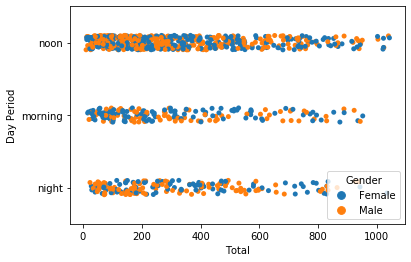

In [11]:
grafico = sns.stripplot(y = 'Day Period', x = 'Total', hue = 'Gender', data=sales)

Text(0.5, 1.0, 'Ventas por mes')

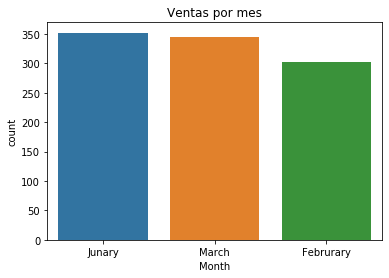

In [12]:
grafico = sns.countplot(x='Month', data = sales)
grafico.set_title("Ventas por mes")

In [13]:
# Tomando en cuenta solo las columnas categoricas
sales_c = sales.copy()

# Eliminando columnas no categoricas
if 'Invoice ID' in sales:
    del sales['Invoice ID']
if 'Unit price' in sales:
    del sales['Unit price']
if 'Tax 5%' in sales:
    del sales['Tax 5%']
if 'Total' in sales:
    del sales['Total']
if 'cogs' in sales:
    del sales['cogs']
if 'gross margin percentage' in sales:
    del sales['gross margin percentage']
if 'gross income' in sales:
    del sales['gross income']
if 'Rating' in sales:
    del sales['Rating']
if 'Time' in sales:
    del sales['Time']
if 'Date' in sales:
    del sales['Date']
print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
Branch           1000 non-null object
City             1000 non-null object
Customer type    1000 non-null object
Gender           1000 non-null object
Product line     1000 non-null object
Quantity         1000 non-null int64
Payment          1000 non-null object
Month            1000 non-null object
Day Period       1000 non-null object
dtypes: int64(1), object(8)
memory usage: 70.4+ KB
None


Branch       City Customer type  Gender            Product line  Quantity  \
0      A     Yangon        Member  Female       Health and beauty         7   
1      C  Naypyitaw        Normal  Female  Electronic accessories         5   
2      A     Yangon        Normal    Male      Home and lifestyle         7   
3      A     Yangon        Member    Male       Health and beauty         8   
4      A     Yangon        Normal    Male       Sports and travel         7   

       Payment      Month Day Period  
0      Ewallet     Junary       noon  
1         Cash      March    morning  
2  Credit card      March       noon  
3      Ewallet     Junary      night  
4      Ewallet  Februrary    morning

In [14]:
sales.columns

Index(['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Quantity',
       'Payment', 'Month', 'Day Period'],
      dtype='object')

In [20]:
#print(sales['Product line'].values)
print(sales['Product line'].unique())

['Health and beauty' 'Electronic accessories' 'Home and lifestyle'
 'Sports and travel' 'Food and beverages' 'Fashion accessories']


### NOTA IMPORATANTE
Este notebook solo esta como prueba, por que la parte de aplicación del algoritmo a priori puede no estar correcta.

In [258]:
# Usando TransactionEncoder https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
te = TransactionEncoder()
te_ary = te.fit(records).transform(records)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

1     10      2      3      4      5      6      7      8      9  \
0    False  False  False  False  False  False  False   True  False  False   
1    False  False  False  False  False   True  False  False  False  False   
2    False  False  False  False  False  False  False   True  False  False   
3    False  False  False  False  False  False  False  False   True  False   
4    False  False  False  False  False  False  False   True  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
995   True  False  False  False  False  False  False  False  False  False   
996  False   True  False  False  False  False  False  False  False  False   
997   True  False  False  False  False  False  False  False  False  False   
998   True  False  False  False  False  False  False  False  False  False   
999  False  False  False  False  False  False  False   True  False  False   

     ...  Mandalay  March  Member  Naypyitaw  Normal  Sports and travel  \
0    ...     False  False    True      False   False              False   
1    ...     False   True   False       True    True              False   
2    ...     False   True   False      False    True              False   
3    ...     False  False    True      False   False              False   
4    ...     False  False   False      False    True               True   
..   ...       ...    ...     ...        ...     ...                ...   
995  ...     False  False   False       True    True              False   
996  ...      True   True   False      False    True              False   
997  ...     False  False    True      False   False              False   
998  ...     False  False   False      False    True              False   
999  ...     False  False    True      False   False              False   

     Yangon  morning  night   noon  
0      True    False  False   True  
1     False     True  False  False  
2      True    False  False   True  
3      True    False   True  False  
4      True     True  False  False  
..      ...      ...    ...    ...  
995   False    False  False   True  
996   False    False  False   True  
997    True    False  False   True  
998    True    False  False   True  
999    True    False  False   True  

[1000 rows x 35 columns]

In [259]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets

support                      itemsets
0      0.112                           (1)
1      0.119                          (10)
2      0.109                           (4)
3      0.102                           (5)
4      0.102                           (7)
..       ...                           ...
220    0.109     (A, Yangon, Normal, noon)
221    0.113     (Male, B, Mandalay, noon)
222    0.101   (Mandalay, B, noon, Member)
223    0.114  (Naypyitaw, C, noon, Female)
224    0.107  (Naypyitaw, C, noon, Member)

[225 rows x 2 columns]

In [271]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

antecedents consequents  antecedent support  consequent support  support  \
0         (A)   (Ewallet)               0.340               0.345    0.126   
1   (Ewallet)         (A)               0.345               0.340    0.126   
2         (A)      (Male)               0.340               0.499    0.179   
3      (Male)         (A)               0.499               0.340    0.179   
4         (A)     (March)               0.340               0.345    0.127   

   confidence      lift  leverage  conviction  
0    0.370588  1.074169   0.00870    1.040654  
1    0.365217  1.074169   0.00870    1.039726  
2    0.526471  1.055051   0.00934    1.058012  
3    0.358717  1.055051   0.00934    1.029187  
4    0.373529  1.082694   0.00970    1.045540

In [270]:
# Las 30 primeras reglas con mayor condfidence, es decir la proporción de transacciones
# que contienen el consecuente y que también contienen el antecedente.
rules.sort_values('confidence', ascending=True).head(10)

antecedents             consequents  antecedent support  \
361      (noon)         (March, Female)               0.621   
304      (noon)             (C, Member)               0.621   
534      (noon)  (Naypyitaw, C, Member)               0.621   
422      (noon)     (Naypyitaw, Member)               0.621   
338      (noon)       (Ewallet, Female)               0.621   
377      (noon)        (Yangon, Female)               0.621   
332      (noon)   (Credit card, Member)               0.621   
427      (noon)        (Yangon, Member)               0.621   
185      (noon)             (A, Normal)               0.621   
433      (noon)        (Yangon, Normal)               0.621   

     consequent support  support  confidence      lift  leverage  conviction  
361               0.161    0.105    0.169082  1.050200  0.005019    1.009727  
304               0.169    0.107    0.172303  1.019543  0.002051    1.003990  
534               0.169    0.107    0.172303  1.019543  0.002051    1.003990  
422               0.169    0.107    0.172303  1.019543  0.002051    1.003990  
338               0.160    0.109    0.175523  1.097021  0.009640    1.018828  
377               0.161    0.109    0.175523  1.090207  0.009019    1.017615  
332               0.172    0.109    0.175523  1.020485  0.002188    1.004273  
427               0.167    0.109    0.175523  1.051038  0.005293    1.010338  
185               0.173    0.109    0.175523  1.014586  0.001567    1.003061  
433               0.173    0.109    0.175523  1.014586  0.001567    1.003061

In [279]:
# Las 50 primeras reglas que tienen mayor asociación (lift)
rules[['antecedents','consequents', 'lift']].sort_values('lift', ascending=False).head(50)
#rules[['antecedents','consequents', 'lift']].sort_values('lift', ascending=False)[140:200]

antecedents          consequents      lift
488                  (Male, B)     (Mandalay, noon)  3.374142
489           (Male, Mandalay)            (B, noon)  3.374142
493           (Mandalay, noon)            (Male, B)  3.374142
492                  (B, noon)     (Male, Mandalay)  3.374142
513          (Naypyitaw, noon)          (C, Female)  3.108978
515                  (C, noon)  (Naypyitaw, Female)  3.108978
514        (Naypyitaw, Female)            (C, noon)  3.108978
516                (C, Female)    (Naypyitaw, noon)  3.108978
502         (Mandalay, Member)            (B, noon)  3.107214
504                (B, Member)     (Mandalay, noon)  3.107214
503                  (B, noon)   (Mandalay, Member)  3.107214
501           (Mandalay, noon)          (B, Member)  3.107214
438                  (A, noon)     (Yangon, Female)  3.105590
440             (Yangon, noon)          (A, Female)  3.105590
439                (A, Female)       (Yangon, noon)  3.105590
441           (Yangon, Female)            (A, noon)  3.105590
528        (Naypyitaw, Member)            (C, noon)  3.073476
527          (Naypyitaw, noon)          (C, Member)  3.073476
530                (C, Member)    (Naypyitaw, noon)  3.073476
529                  (C, noon)  (Naypyitaw, Member)  3.073476
280        (Junary, Naypyitaw)                  (C)  3.048780
309                (Naypyitaw)          (Normal, C)  3.048780
311          (Naypyitaw, noon)                  (C)  3.048780
253          (Naypyitaw, Cash)                  (C)  3.048780
270                (C, Female)          (Naypyitaw)  3.048780
269        (Naypyitaw, Female)                  (C)  3.048780
312                  (C, noon)          (Naypyitaw)  3.048780
298                        (C)  (Naypyitaw, Member)  3.048780
281                (Junary, C)          (Naypyitaw)  3.048780
263     (Februrary, Naypyitaw)                  (C)  3.048780
262             (Februrary, C)          (Naypyitaw)  3.048780
259               (C, Ewallet)          (Naypyitaw)  3.048780
258       (Naypyitaw, Ewallet)                  (C)  3.048780
256                        (C)    (Naypyitaw, Cash)  3.048780
255                (Naypyitaw)            (C, Cash)  3.048780
297                (Naypyitaw)          (C, Member)  3.048780
254                  (C, Cash)          (Naypyitaw)  3.048780
308                        (C)  (Normal, Naypyitaw)  3.048780
285                        (C)  (Junary, Naypyitaw)  3.048780
306                (Normal, C)          (Naypyitaw)  3.048780
525          (C, noon, Member)          (Naypyitaw)  3.048780
524  (Naypyitaw, noon, Member)                  (C)  3.048780
291                 (C, March)          (Naypyitaw)  3.048780
295        (Naypyitaw, Member)                  (C)  3.048780
290         (Naypyitaw, March)                  (C)  3.048780
289                (Naypyitaw)            (Male, C)  3.048780
288                        (C)    (Male, Naypyitaw)  3.048780
287          (Male, Naypyitaw)                  (C)  3.048780
286                  (Male, C)          (Naypyitaw)  3.048780
296                (C, Member)          (Naypyitaw)  3.048780

De estos resultados de asociación se puede rescatar algunas dependencias:

- Que un cliente sea Varón y de la ciudad de Mandalay incrementa las probabilidades de que la compra sea en la mañana y el producto sea de marca B en 2.374 (237.4%).
- Que una cliente sea Mujer y de la ciudad de Uangon incrementa las probabildiades de que la compra ocurra en la mañana y el producto sea de la marca A en 2.10 (210%).
- Que un cliente sea Mujer y de la ciudad de Naypyitaw incrementa en 2.048 veces las probabilidades de que la marca del producto comprado sea C.
- Que un cliente sea Varón y de la ciudad de Naypyitaw incrementa en 2.048 veces las probabilidades de que la marca del producto comprado sea C.

In [275]:
# Reglas adicionales
def reglasAsociacion(dataset, min_threshold=1):
    records = []
    for i in range(len(dataset)):
        records.append([str(dataset.values[i,j]) for j in range(len(dataset.columns))])
    te = TransactionEncoder()
    te_ary = te.fit(records).transform(records)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    return rules

In [264]:
# Analizando solamente el género de los compradores con la línea de productos
sales1 = sales[['Gender','Product line']]
#print(sales1.head())
rules1 = reglasAsociacion(sales1)
rules1.sort_values('lift', ascending=True).head(15)[['antecedents', 'consequents', 'lift']]

antecedents               consequents      lift
0                     (Male)  (Electronic accessories)  1.013792
1   (Electronic accessories)                    (Male)  1.013792
10                    (Male)      (Home and lifestyle)  1.014529
11      (Home and lifestyle)                    (Male)  1.014529
4       (Food and beverages)                  (Female)  1.032418
5                   (Female)      (Food and beverages)  1.032418
6        (Sports and travel)                  (Female)  1.058125
7                   (Female)       (Sports and travel)  1.058125
2      (Fashion accessories)                  (Female)  1.076499
3                   (Female)     (Fashion accessories)  1.076499
8                     (Male)       (Health and beauty)  1.160215
9        (Health and beauty)                    (Male)  1.160215

Se puede ver que no hay relaciones de dependencia entre variables Gender y Product Line es casi nula, por lo que se puede concluir que la venta de productos en líneas de productos no depende del género.

In [265]:
sales2 = sales[['City','Product line']].copy()
rules2 = reglasAsociacion(sales2)
rules2.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'lift']]

antecedents            consequents      lift
13   (Home and lifestyle)               (Yangon)  1.194853
12               (Yangon)   (Home and lifestyle)  1.194853
6             (Naypyitaw)   (Food and beverages)  1.156434
7    (Food and beverages)            (Naypyitaw)  1.156434
15    (Sports and travel)             (Mandalay)  1.124982
14             (Mandalay)    (Sports and travel)  1.124982
4   (Fashion accessories)            (Naypyitaw)  1.113319
5             (Naypyitaw)  (Fashion accessories)  1.113319
9     (Health and beauty)             (Mandalay)  1.050254
8              (Mandalay)    (Health and beauty)  1.050254

El caso de **City** y **Product Line** muestra una relación de dependencia pequeña entre que la línea de producto sea por ejemplo "Home and lifestyle" y que la compra sea en la ciudad de "Yangon". Es decir que un producto sea de la línea "Home and lifestyle" incrementa en 0.1948% la probabilidad de que esta compra sea de la ciudad de "Yangon". 0.1948 no se puede considerar como un valor relevante.

In [266]:
sales3 = sales[['Payment','Product line']].copy()
rules3 = reglasAsociacion(sales3)
rules3.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'lift']]

antecedents               consequents      lift
0                     (Cash)  (Electronic accessories)  1.214090
1   (Electronic accessories)                    (Cash)  1.214090
16      (Home and lifestyle)                 (Ewallet)  1.159420
17                 (Ewallet)      (Home and lifestyle)  1.159420
6              (Credit card)      (Food and beverages)  1.127250
7       (Food and beverages)             (Credit card)  1.127250
13                 (Ewallet)     (Fashion accessories)  1.058460
12     (Fashion accessories)                 (Ewallet)  1.058460
8              (Credit card)       (Health and beauty)  1.057709
9        (Health and beauty)             (Credit card)  1.057709

Para **Payment** y **Product Line** las mejores relaciones de dependencia son de 1.21, esto indica un bajo nivel de dependencia entre estas variables.

In [276]:
sales4 = sales[['Payment','Day Period']].copy()
rules4 = reglasAsociacion(sales4)
rules4.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'lift']]

antecedents    consequents      lift
0      (morning)         (Cash)  1.111043
1         (Cash)      (morning)  1.111043
6        (night)      (Ewallet)  1.079248
7      (Ewallet)        (night)  1.079248
5  (Credit card)        (night)  1.026202
4        (night)  (Credit card)  1.026202
8         (noon)      (Ewallet)  1.012859
9      (Ewallet)         (noon)  1.012859
2      (morning)  (Credit card)  1.010084
3  (Credit card)      (morning)  1.010084

### Conclusiones

Se puede ver que usando la técnica de reglas de asociación se pueden hallar relaciones de dependencias entre la ocurrencia de las variables en la venta de productos de supermercados para el dataset dado. Existen relaciones de alta dependencia especialmente entre la **ciudad**, **marcas**, **género** y periódo del día (en espcial en las mañanas)en que se vende como se muestran en los resultados anteriores.